In [10]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
import json, matplotlib
s = json.load( open("styles/bmh_matplotlibrc.json") )
matplotlib.rcParams.update(s)
from IPython.core.pylabtools import figsize
figsize(11, 5)
colores = ["#348ABD", "#A60628","#06A628"]

from ipywidgets import interact, interact_manual, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

### Remueve esta línea de código, pues agregarás tus propias funciones
#from HodkinHuxley.EulerSimulation import *

# Modelo de Hodkin-Huxley

\begin{align}
 C_m \frac{dV}{dt} &= -g_{Na}m^3h(V-E_{Na}) - g_K n^4 (V - E_K) \label{eq:huxley_voltage} \\ \nonumber
                   &- g_L (V - E_L) + I_{ext} \\
 \frac{1}{\gamma(T)} \frac{dn}{dt} &= \alpha_n(V) (1 - n) - \beta_n(V)n = \frac{n^{\infty}(V) - n}{\tau_n(V)} \label{eq:huxley_sodio} \\
 \frac{1}{\gamma(T)} \frac{dm}{dt} &= \alpha_m(V) (1 - m) - \beta_m(V)m = \frac{m^{\infty}(V) - m}{\tau_m(V)} \label{eq:huxley_sodio_compuerta} \\
 \frac{1}{\gamma(T)} \frac{dh}{dt} &= \alpha_h(V) (1 - h) - \beta_h(V)h = \frac{h^{\infty}(V) - h}{\tau_h(V)} \label{eq:huxley_sodio_puerta} \\
 \tau_n(V) &= \frac{1}{\alpha_n(V) + \beta_n(V)} \\
 n_{\infty}(V) &= \frac{\alpha_n(V)}{\alpha_n(V) + \beta_n(V)}
\end{align}

Con [Wells]:
* $C_m = 1.0\ \mu\text{F/cm}^2$ la capacitancia de la membrana por unidad de área
* $V$ la diferencia de potencial en la membrana
* $g_{Na} = 120\ \text{mS/cm}^2$ la conductancia máxima por unidad de área para el sodio
* $g_{K} = 36\ \text{mS/cm}^2$ la conductancia máxima por unidad de área para el potasio
* $g_{L} = 0.3\ \text{mS/cm}^2$ la conductancia adicional, independiente del voltaje
* $E_{Na} = 55\ \text{mV}$ el voltaje de la batería en la compuerta de sodio
* $E_{K} = -72\ \text{mV}$ el voltaje de la batería en la compuerta de potasio
* $E_{L} = -49.387\ \text{mV}$ el voltaje filtrado
* $\gamma(T)$ es una constante de proporcionalidad temporal que depende de la temperatura $T$, a $6.3°$C vale $1$ [Cessac2009].

para el caso del calamar.  Los potenciales están medidos considerando que la membrana se encuentra en su potencial de reposo a los $V_r = -60\ \text{mV}$.  Las corrientes $I$ están medidas en $\mu$A/cm$^2$.

Las funciones de transición $\alpha(V)$ y $\beta(V)$, fueron determinadas experimentalmente.  Su forma general es:
\begin{align}
  \alpha(V) \text{ ó } \beta(V) = \frac{A + BV}{C + H e^{\left(\frac{V+D}{F}\right)}}
\end{align}
donde $V$ está medido con respecto al potencial de reposo $V_r$

Los valores medidos por Hodkin y Huxley para la compuerta de **potasio (K)**, fueron:
\begin{align}
  \alpha_n(V) &= \frac{0.01(10 - V)}{e^{\left(\frac{10-V}{10}\right)} - 1} & \beta_n(V) &= 0.125 e^{-\frac{V}{80}}
\end{align}
Observemos que cuando $V = 10$ la función está indefinida.  Utilizando la regla de L'Hopital, se calcula el límite:
\begin{align}
  \alpha_n(10) &= \frac{-0.01}{e^{\left(\frac{10-V}{10}\right)}(-0.1)}
               = \frac{-0.01}{-0.1} = 0.1
\end{align}

In [51]:
## Programa las función alfa_n como función del voltaje V.
## Necesitarás definir un caso especial cuando V - 10 < epsilon
## Utiliza esta celda para ver como se comporta tu función en esta vecindad
## y elegir un valor de epsilon adecuado

def al_n(voltaje):
    if (np.isclose(voltaje,10)):
        return 0.1
    else:
        dividend = 0.01 * (10 - voltaje)
        divisor = np.exp((10-voltaje)/10) - 1
        return dividend/divisor

alpha_n = np.vectorize(al_n)
    
    
@interact(
    step = widgets.FloatSlider(min=0.0001, max=0.2, step=0.0001, value=0.1),
)
def plotAlphaLimit(step):
    V = np.arange(9.5, 10.5, step)
    alpha = alpha_n(V)
    plt.plot(V, alpha)

interactive(children=(FloatSlider(value=0.1, description='step', max=0.2, min=0.0001, step=0.0001), Output()),…

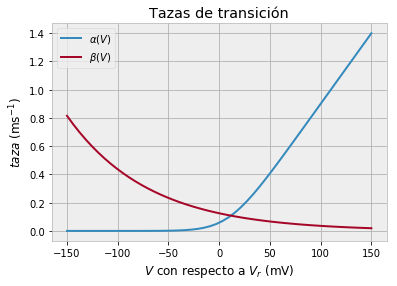

In [52]:
## Programa la funciones como función del voltaje V, para la compuerta de K
## Genera luego una gráfica de alfa_n y beta_n

# beta_n
def b_n(voltaje):
    return (0.125*np.exp(-voltaje/80))
        
beta_n = np.vectorize(b_n)

def plotAlpha():
    V = np.linspace(-150, 150)
    alpha = alpha_n(V)
    beta = beta_n(V)
    plt.plot(V, alpha, label="$\\alpha(V)$")
    plt.plot(V, beta, label="$\\beta(V)$")
    plt.title("Tazas de transición")
    plt.xlabel("$V$ con respecto a $V_r$ (mV)")
    plt.ylabel("$taza$ (ms$^{-1}$)")
    plt.legend()
plotAlpha()

Las funciones para el **sodio (Na)** son:
\begin{align}
  \alpha_m(V) &= \frac{0.1(25 - V)}{e^{\left(\frac{25-V}{10}\right)} - 1} & \beta_m(V) &= 4 e^{-\frac{V}{18}} \\
  \alpha_h(V) &= 0.07 e^{-\frac{V}{20}} & \beta_h(V) &= \frac{1}{e^{\left(\frac{30-V}{10}\right)} + 1}
\end{align}
Para $\alpha_m$ cuando $V = 25$, utilizamos la regla de L'Hopital para calcular el límite:
\begin{align}
  \alpha_m(25) &= \frac{-0.1}{e^{\left(\frac{25-V}{10}\right)}(-0.1)}
               = \frac{-0.1}{-0.1} = 1
\end{align}

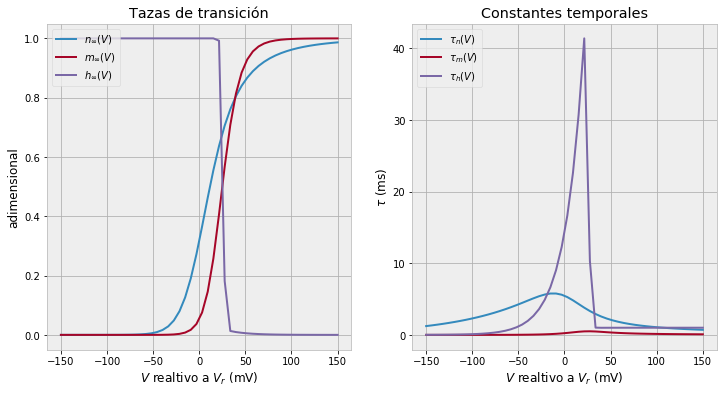

In [56]:
## Dadas alfa y beta, calcular ahora y graficar n y tau para ambos canales.

## Agrega las funciones correspondientes para la compuerta de sodio también,
## deduce sus firmas a partir de las llamadas en la función para graficar


def al_m(voltaje):
    if(np.isclose(voltaje,25)):
        return 1
    return (0.1*(25-voltaje))/(np.exp((25-voltaje)/10) -1)

def b_m(voltaje):
    return (4*np.exp(-voltaje/18))
def al_h(voltaje):
    return (0.07*np.exp(-voltaje/20))
def b_h(voltaje):
    return (1/(np.exp(30-voltaje) + 1))

alpha_m = np.vectorize(al_m)
beta_m = np.vectorize(b_m)
alpha_h = np.vectorize(al_h)
beta_h = np.vectorize(b_h)

def n(alpha, beta):
    return alpha/(alpha+beta)
    

def tau(alpha, beta):
    return 1/(alpha+beta)

def plotParameters():
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    V = np.linspace(-150, 150)
    alpha = alpha_n(V)
    beta = beta_n(V)
    axes[0].plot(V, n(alpha, beta), label="$n_{\infty}(V)$")
    axes[1].plot(V, tau(alpha, beta), label="$\\tau_{n}(V)$")
    
    alpha = alpha_m(V)
    beta = beta_m(V)
    axes[0].plot(V, n(alpha, beta), label="$m_{\infty}(V)$")
    axes[1].plot(V, tau(alpha, beta), label="$\\tau_{m}(V)$")
    
    alpha = alpha_h(V)
    beta = beta_h(V)
    axes[0].plot(V, n(alpha, beta), label="$h_{\infty}(V)$")
    axes[1].plot(V, tau(alpha, beta), label="$\\tau_{h}(V)$")
    
    axes[0].set_title("Tazas de transición")
    axes[0].set_xlabel("$V$ realtivo a $V_r$ (mV)")
    axes[0].set_ylabel("adimensional")
    axes[0].legend(loc=2)
    axes[1].set_title("Constantes temporales")
    axes[1].set_xlabel("$V$ realtivo a $V_r$ (mV)")
    axes[1].set_ylabel("$\\tau$ (ms)")
    axes[1].legend(loc=2)
plotParameters()

## Simulación con el método numérico de Euler

El método de Euler realiza una aproxima a la función por su tangente.  Dada una ecuación diferencial de la forma:

\begin{align}
  \frac{dy(t)}{dt} = f(y(t))
\end{align}

Partimos de un punto inicial $(t_0, y_0)$ y a partir de él, se calcula el valor de $y$ para el tiempo $t + \Delta t$ iterativamente como:

\begin{align}
  y(t + \Delta t) &= y(t) + \Delta t f(y(t))
\end{align}

El error aproximado por realizar esta aproximación es:
\begin{align}
  E =& \frac{1}{2} \frac{df(t)}{dt}(\Delta t)^2
\end{align}

Aplicando esta fórmula a la ecuación para los canales:

\begin{align}
 \frac{dn}{dt} &= \frac{n^{\infty}(V) - n}{\tau_n(V)}
\end{align}

Obtenemos:

\begin{align}
 n(t + \Delta t) =& n(t) + \Delta t \left[\frac{n^{\infty}(V)}{\tau_n} - \frac{n(t)}{\tau_n(V)} \right] \\
                 =& \left[ 1 - \frac{\Delta t}{\tau_n(V)} \right] n(t) + \frac{\Delta t}{\tau_n(V)}n^{\infty}(V)
\end{align}

Se obtienen fórmulas análogas para $m$ y $h$.  Todas juntas pueden ser escritas en forma matricial:

\begin{align}
  \begin{bmatrix}
  n(t + \Delta t) \\
  m(t + \Delta t) \\
  h(t + \Delta t)
  \end{bmatrix} =& 
  \begin{bmatrix}
  (1 - \Delta t/\tau_n(V)) & 0 & 0 \\
  0 & (1 - \Delta t/\tau_m(V)) & 0 \\
  0 & 0 & (1 - \Delta t/\tau_h(V)) \\
  \end{bmatrix}
  \begin{bmatrix}
  n(t) \\
  m(t) \\
  h(t)
  \end{bmatrix} +
  \begin{bmatrix}
  (\Delta t / \tau_n(V)) n^{\infty}(V) \\
  (\Delta t / \tau_m(V)) m^{\infty}(V) \\
  (\Delta t / \tau_h(V)) h^{\infty}(V)
  \end{bmatrix}
\end{align}

Brevemente:

\begin{align}
  \boldsymbol{\Pi}(t + \Delta t) =& \boldsymbol{A}_\pi \boldsymbol{\Pi}(t) + \boldsymbol{B}_\pi
\end{align}

Se debe realizar el mismo procedimiento con la ecuación diferencial para el voltaje.  Para simplificar la notación, introduzcamos:

\begin{align}
  G_{Na} &= g_{Na}m^3h   &   G_{K} &= g_K n^4
\end{align}

Entonces:
\begin{align}
 C_m \frac{dV}{dt} &= -g_{Na}m^3h(V-E_{Na}) - g_K n^4 (V - E_K) - g_L (V - E_L) + I_{ext} \\
 \frac{dV}{dt} &= -\frac{G_{Na}}{C_m}(V-E_{Na}) - \frac{G_K}{C_m} (V - E_K) - \frac{g_L}{C_m} (V - E_L) + \frac{1}{C_m}I_{ext}
\end{align}

Utilizando el método de Euler:

\begin{align}
 V(t + \Delta t) &= V(t) - \frac{\Delta t}{C_m} \left[ G_{Na}(V-E_{Na}) + G_K (V - E_K) + g_L (V - E_L) + I_{ext}(t) \right] \\
 V(t + \Delta t) &= V(t) - \Delta t \begin{bmatrix} \frac{G_{Na}}{C_m} & \frac{G_K}{C_m} & \frac{g_L}{C_m} \end{bmatrix}  \begin{bmatrix}
                 V(t)-E_{Na} \\
                 V(t)- E_K \\
                 V(t) - E_L
                \end{bmatrix} + \frac{\Delta t}{C_m}I_{ext}(t)
\end{align}

Para los valores por defecto propuestos en la celda siguiente, programar una simulación utilizando el método de Euler produce la figura siguiente:

<img src="figuras/Simulacion.png">

interactive(children=(FloatSlider(value=0.0, description='V0', max=120.0, min=-90.0, step=1.0), FloatSlider(va…

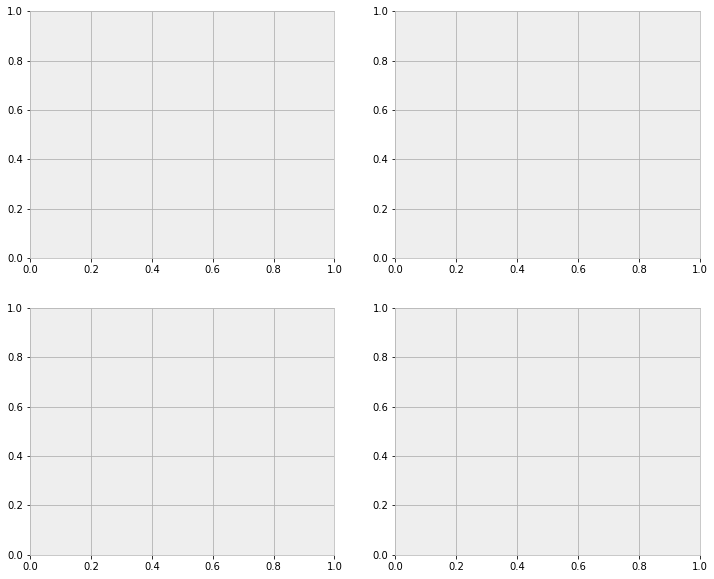

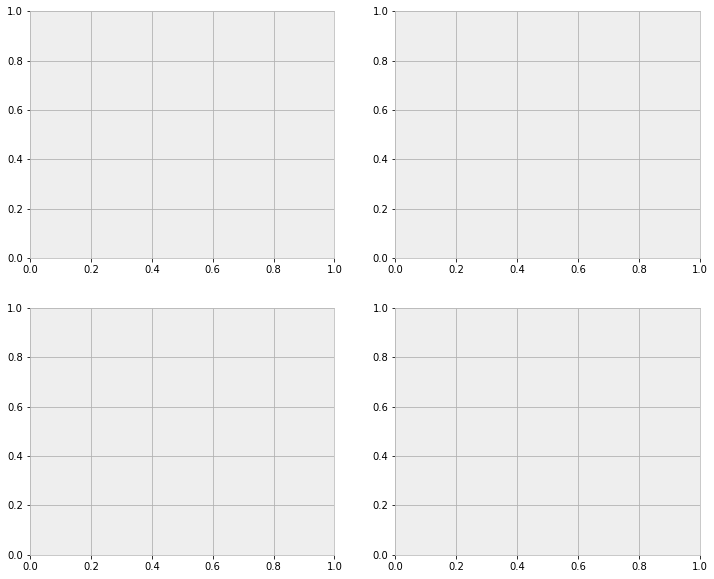

In [63]:
parametros = {
    'DeltaT' : 0.01,   # ms cada cuanto voy recorriendo
    'maxT' : 50.0,     # ms tiempo maximo
    'V0' : 0.0,        # mV 
    'gNa' : 120.0,     # mS/cm2
    'gK' : 36.0,
    'gL' : 0.3,
    'Cm' : 1.0,          # micro F/cm2
    'ENa' : 115.0,     # Utilizando la convensión original de Hodkin-Huxley
    'EK' : -12.0,
    'EL' : 10.613
    }

def makeIext(t0 = 10.0, tfin = 16.0, current = 6.5):
    def Iext(t):
        """ Devuelve el valor de la corriente aplicada a la membrana, al tiempo t, en microampers.
        """
        if t > t0 and t < tfin:
            return current    # micro A/cm2
        else:
            return 0
    return Iext

## Implementa aquí el algoritmo de intregración numérica de Euler para calcular V(t)
##
## Asegúrate de que, al ejecutar la simulación con los parámetros por defecto,
## se reproduce la imagen de arriba.
##
## Después prueba con pulsos de t en 10->30, con corrientes de 10 y -10 microamperes
## ¿Qué observas?
##
## Inserta al final una celda con tus comentarios y resultados

def EulerHodkinHuxley(DeltaT, maxT, V0, gNa, gK, gL, Cm, ENa, EK, EL, Iext):
    T = np.arange(0,maxT, DeltaT)
    N = np.zeros(len(T))
    M = np.zeros(len(T))
    H = np.zeros(len(T))
    GNa = np.zeros(len(T))
    GK = np.zeros(len(T))
    GL = np.zeros(len(T))
    V = np.zeros(len(T))
    tauN = np.zeros(len(T))
    tauM = np.zeros(len(T))
    tauH = np.zeros(len(T))
    V[0] = V0
    
    #al0n = np.vectorize(al_n)
    alpha0n = al_n(V[0])
    
    
    #b0n = np.vectorize(b_n)
    beta0n = b_n(V[0])
    
    N[0] = n(alpha0n,beta0n)
    tauN[0] = tau(alpha0n, beta0n)

    #al0m = np.vectorize(al_m)
    alpha0m = al_m(V[0])
    #b0m = np.vectorize(b_m)
    beta0m = b_m(V[0])
    
    M[0] = n(alpha0m, beta0m)
    tauM[0] = tau(alpha0m,beta0m)
    
    #al0h = np.vectorize(al_h)
    alpha0h = al_h(V[0])
    #b0h = np.vectorize(b_h)
    beta0h = b_h(V[0])
    
    H[0] = n(alpha0h, beta0h)
    tauH[0] = tau(alpha0h,beta0h)
    
    GNa[0] = gNa*M[0]**3*H[0]
    GK[0] = gK*N[0]**4
    
    for t in enumerate(T):
        
        print()
    
    
def plotSimulation(resultado):
    fig, axes = plt.subplots(2, 2, figsize=(12,10))[t]
    tiempo = resultado['T']
    axes[0][0].plot(tiempo, resultado['V'])
    
    axes[0][0].set_title("Voltaje en la membrana")
    axes[0][0].set_xlabel("t (ms)")
    axes[0][0].set_ylabel("Voltaje relativo en la membrana (mV)")
        
    axes[0][1].plot(tiempo, resultado['GK'], label="$G_{K}$")
    axes[0][1].plot(tiempo, resultado['GNa'], label="$G_{Na}$")
    
    axes[0][1].set_title("Conductancia de los canales")
    axes[0][1].set_ylabel("Conductancia (mS/cm$^2$)")
    axes[0][1].set_xlabel("t (ms)")
    axes[0][1].legend()
    
    axes[1][0].plot(tiempo, resultado['n'], label="$n$")
    axes[1][0].plot(tiempo, resultado['m'], label="$m$")
    axes[1][0].plot(tiempo, resultado['h'], label="$h$")
    axes[1][0].set_title("Tazas de transición")
    axes[1][0].set_xlabel("t (ms)")
    axes[1][0].set_ylabel("adimensional")
    axes[1][0].legend()
    
    axes[1][1].plot(tiempo, resultado['tauN'], label="$\\tau_n$")
    axes[1][1].plot(tiempo, resultado['tauM'], label="$\\tau_m$")
    axes[1][1].plot(tiempo, resultado['tauH'], label="$\\tau_h$")
    axes[1][1].set_title("Constantes temporales")
    axes[1][1].set_xlabel("t (ms)")
    axes[1][1].set_ylabel("$\\tau$ (ms)")
    axes[1][1].legend()
    

@interact_manual(
    V0 = widgets.FloatSlider(min=-90, max=120, step=1, value=parametros['V0']),
    current = widgets.FloatSlider(min=-10, max=10, step=0.1, value=2.4),
    t0 = 10.0,
    tfin = 16.0
)
def simulaHodkinHuxley(V0, t0, tfin, current):
    parametros['Iext'] = makeIext(t0, tfin, current)
    parametros['V0'] = V0
    resultado = EulerHodkinHuxley(**parametros)
    plotSimulation(resultado)

In [64]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()